# Import the dependencies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from itertools import combinations

import sys

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

sys.path.append('../cmeans_math')
import clustering_by_move_evolve as cl_by_me
import cheat_clustering as cheat_clustering

import accuracies
import entry_cluster_assignment

In [2]:
pd.set_option('display.max_columns', None)

# Preprocess data

[dataset link](https://www.kaggle.com/datasets/julnazz/diabetes-health-indicators-dataset/data)

In [3]:
df=pd.read_csv('./data/diabetes_012_health_indicators_BRFSS2021.csv')
df['Diabetes_012'] = [int(x) for x in df['Diabetes_012']]
df.drop(['Income', 'Education'], axis = 1, inplace = True)

In [4]:
df.shape

(236378, 20)

In [5]:
df.duplicated().sum()

50929

In [6]:
df = df.drop_duplicates()

In [7]:
df.shape

(185449, 20)

In [8]:
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0,0,1.0,1,15.0,1.0,0.0,0.0,0,1,1,0,1,0.0,5.0,10.0,20.0,0.0,0,11
1,2,1,0.0,1,28.0,0.0,0.0,1.0,0,1,0,0,1,0.0,2.0,0.0,0.0,0.0,0,11
2,2,1,1.0,1,33.0,0.0,0.0,0.0,1,1,1,0,1,0.0,2.0,10.0,0.0,0.0,0,9
3,2,0,1.0,1,29.0,0.0,1.0,1.0,1,1,1,0,1,0.0,5.0,0.0,30.0,1.0,1,12
4,0,0,0.0,1,24.0,1.0,0.0,0.0,0,0,0,0,1,0.0,3.0,0.0,0.0,1.0,1,13


In [9]:
print(df.isnull().sum())

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185449 entries, 0 to 236377
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          185449 non-null  int64  
 1   HighBP                185449 non-null  int64  
 2   HighChol              185449 non-null  float64
 3   CholCheck             185449 non-null  int64  
 4   BMI                   185449 non-null  float64
 5   Smoker                185449 non-null  float64
 6   Stroke                185449 non-null  float64
 7   HeartDiseaseorAttack  185449 non-null  float64
 8   PhysActivity          185449 non-null  int64  
 9   Fruits                185449 non-null  int64  
 10  Veggies               185449 non-null  int64  
 11  HvyAlcoholConsump     185449 non-null  int64  
 12  AnyHealthcare         185449 non-null  int64  
 13  NoDocbcCost           185449 non-null  float64
 14  GenHlth               185449 non-null  float64
 15  

In [11]:
X=df.drop('Diabetes_012', axis=1)
Y=df['Diabetes_012']

In [12]:
target_col_name='Diabetes_012'

for col_ in X.select_dtypes(include=['int64','int32']).columns.tolist():
    X[col_] = X[col_].astype("float64")

scaler = StandardScaler()
scaler.fit(X)


x_transform_dt = scaler.transform(X)
X = pd.DataFrame(x_transform_dt, columns=X.columns)
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,-0.914063,1.153521,0.215142,-2.092109,1.110966,-0.227358,-0.34393,-1.647657,0.845732,0.507170,-0.284994,0.221272,-0.296577,2.261958,0.591955,1.689728,-0.489836,-0.937668,0.963740
1,1.094017,-0.866911,0.215142,-0.226317,-0.900118,-0.227358,2.90757,-1.647657,0.845732,-1.971724,-0.284994,0.221272,-0.296577,-0.620754,-0.572690,-0.526117,-0.489836,-0.937668,0.963740
2,1.094017,1.153521,0.215142,0.491295,-0.900118,-0.227358,-0.34393,0.606922,0.845732,0.507170,-0.284994,0.221272,-0.296577,-0.620754,0.591955,-0.526117,-0.489836,-0.937668,0.354488
3,-0.914063,1.153521,0.215142,-0.082795,-0.900118,4.398349,2.90757,0.606922,0.845732,0.507170,-0.284994,0.221272,-0.296577,2.261958,-0.572690,2.797650,2.041501,1.066476,1.268365
4,-0.914063,-0.866911,0.215142,-0.800407,1.110966,-0.227358,-0.34393,-1.647657,-1.182408,-1.971724,-0.284994,0.221272,-0.296577,0.340150,-0.572690,-0.526117,2.041501,1.066476,1.572991


In [13]:
X_orig = df.drop('Diabetes_012', axis=1)

for col_ in X_orig.select_dtypes(include=['int64','int32']).columns.tolist():
    X_orig[col_] = X_orig[col_].astype("float64")

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=39)

In [15]:
print("All:", Counter(Y.to_list()))
print("Train:", Counter(y_train.to_list()))
print("Test:", Counter(y_test .to_list()))

All: Counter({0: 148141, 2: 31768, 1: 5540})
Train: Counter({0: 118560, 2: 25389, 1: 4410})
Test: Counter({0: 29581, 2: 6379, 1: 1130})


In [16]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

rfctd=rfc.predict(x_test)
rfcaccuracy = accuracy_score(y_test, rfctd)
print("Test:", rfcaccuracy)

rfctd=rfc.predict(x_train)
rfcaccuracy = accuracy_score(y_train, rfctd)
print("Train:", rfcaccuracy)

Test: 0.773281207872742
Train: 0.9731192580160287


In [17]:
print(rfc.feature_importances_)

[0.03966956 0.0264294  0.00518744 0.24873622 0.03852181 0.01546287
 0.0174838  0.02856081 0.0387464  0.03160945 0.01060357 0.00842678
 0.01574673 0.06410323 0.09134538 0.10182145 0.0225474  0.03142319
 0.1635745 ]


# Visualize with PCA & t-SNE

C:\Users\voldo\AppData\Local\Temp\ipykernel_21952\606341640.py:11: UserWarning: The palette list has more values (15) than needed (3), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,


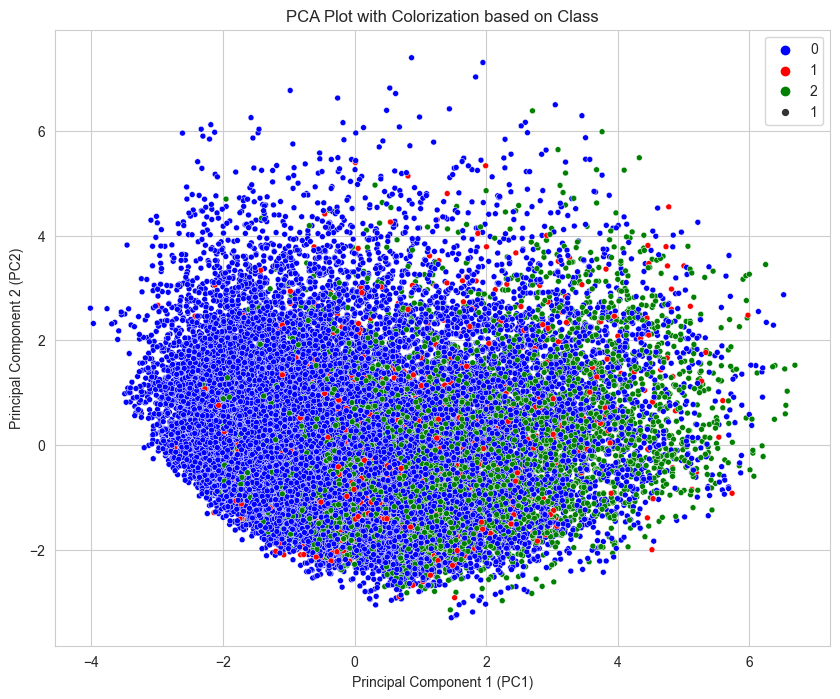

In [32]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(x_test)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['class'] = [int(x) for x in y_test]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,
                palette=['blue', 'red', 'green', 'orange', 'lime', 'purple',
                         'aqua', 'navy', 'coral', 'teal', 'mustard', 'black', 'pink',
                         'maroon', 'yellow'], size=1)
plt.title('PCA Plot with Colorization based on Class')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()

C:\Users\voldo\AppData\Local\Temp\ipykernel_21952\1591967005.py:8: UserWarning: The palette list has more values (15) than needed (3), which may not be intended.
  sns.scatterplot(x='Embed 1', y='Embed 2', hue='class', data=pca_df,


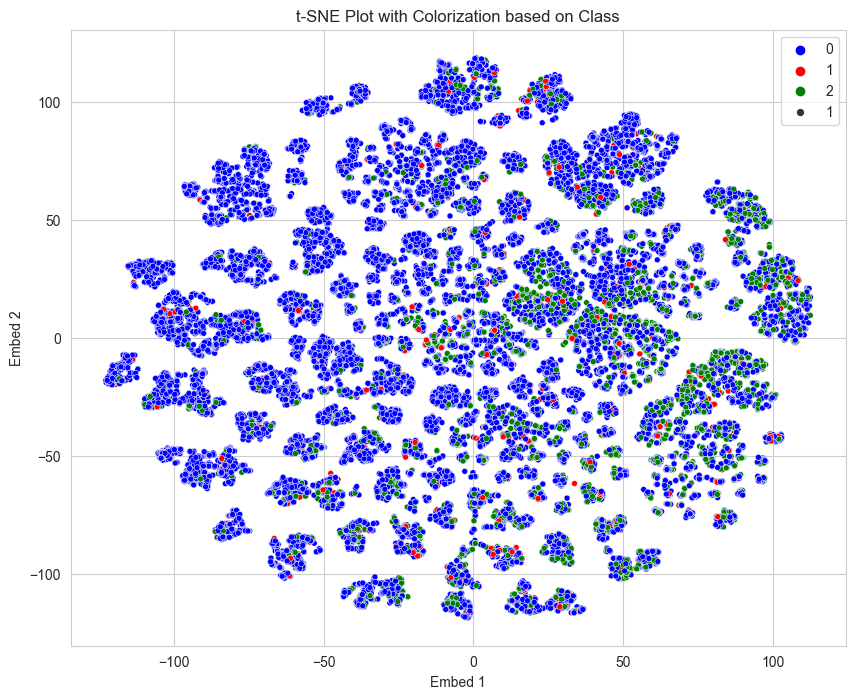

In [33]:
tsne_3d = TSNE(n_components=2, random_state=42)
embedded_data_3d = tsne_3d.fit_transform(x_test)

pca_df = pd.DataFrame(data=embedded_data_3d, columns=['Embed 1', 'Embed 2'])
pca_df['class'] = [int(x) for x in y_test]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Embed 1', y='Embed 2', hue='class', data=pca_df,
                palette=['blue', 'red', 'green', 'orange', 'lime', 'purple',
                         'aqua', 'navy', 'coral', 'teal', 'mustard', 'black', 'pink',
                         'maroon', 'yellow'], size=1)
plt.title('t-SNE Plot with Colorization based on Class')
plt.xlabel('Embed 1')
plt.ylabel('Embed 2')
plt.legend()
plt.show()

Explained Variance Ratio:
[0.14655658 0.09137214 0.06743172 0.06520403 0.05852732 0.05547944
 0.05178178 0.05120783 0.04769089 0.04491682 0.04385959 0.04119574
 0.03988711 0.03924945 0.03740575 0.03645023 0.03104155 0.02599221
 0.0247498 ]


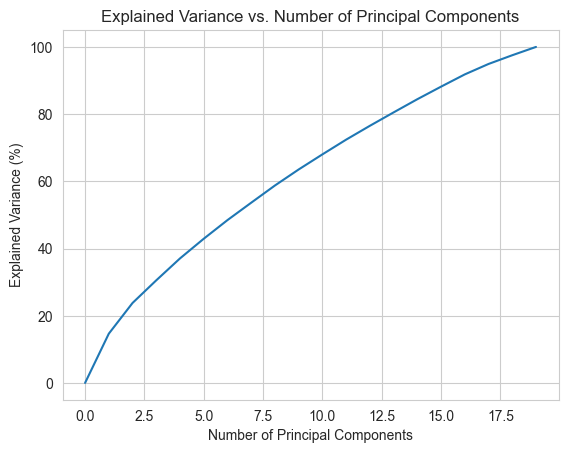

In [34]:
pca = PCA()
pca_result = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_

print("Explained Variance Ratio:") 
print(explained_variance_ratio)

evr_list = list(explained_variance_ratio)
evr_list.insert(0, 0.0)
plt.plot(np.cumsum(np.array(evr_list) * 100))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

Explained Variance Ratio:
[4.58244715e-01 2.63490846e-01 2.19481084e-01 4.62178673e-02
 3.60091498e-03 1.32030828e-03 1.16864236e-03 1.08544373e-03
 1.02503917e-03 8.27926536e-04 7.88859594e-04 6.53767578e-04
 5.01176023e-04 3.79373829e-04 3.47907435e-04 3.08444402e-04
 1.99633925e-04 1.97435177e-04 1.60614557e-04]


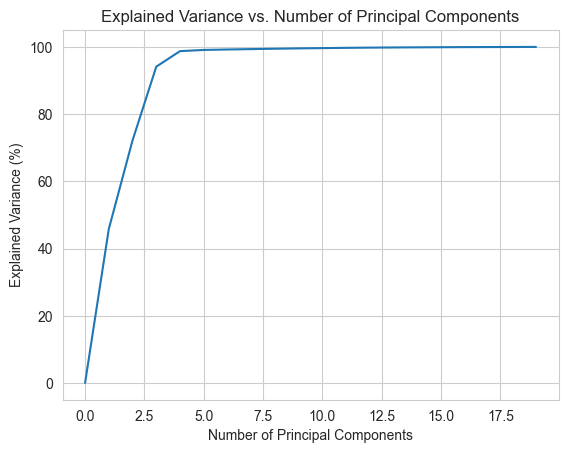

In [15]:
pca = PCA()
pca_result = pca.fit_transform(X_orig)

explained_variance_ratio = pca.explained_variance_ratio_

print("Explained Variance Ratio:") 
print(explained_variance_ratio)

evr_list = list(explained_variance_ratio)
evr_list.insert(0, 0.0)
plt.plot(np.cumsum(np.array(evr_list) * 100))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

# Clusterize data

# IV Kulback-Leibler

In [18]:
obj_results = cheat_clustering.cheat_with_noises_clustering(mat_entries=np.array(x_train),
                                                            vec_check=y_train.tolist(),
                                                            var_count_clusters=3,
                                                            # var_noise=0.18, # for PCA
                                                            var_noise=0.00,
                                                            distance="Mahalanobis")

# obj_results = cheat_clustering.cheat_with_noises_clustering(mat_entries=np.array(x_train),
#                                                             vec_check=y_train.to_list(),
#                                                             var_count_clusters=3,
#                                                             # var_noise=0.18, # for PCA
#                                                             var_noise=0.3,
#                                                             # distance="Mahalanobis")
#                                                             distance="Manhattan")

In [19]:
var_accuracy = accuracies.accuracy(obj_results.mat_cluster_entry_indexes, y_train.tolist())
mat_confusion = accuracies.confusion_matrix(obj_results.mat_cluster_entry_indexes, y_train.tolist())
# accuracies.print_cluster_num(obj_results.mat_cluster_entry_indexes, y_train.tolist())

print("accuracy:", var_accuracy)

accuracy: 0.5475973820260315


In [20]:
for vec_confusion in mat_confusion:
    print(vec_confusion)
mat_cluster_entry_indexes_train = []
mat_cluster_entry_indexes_test = []

if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(np.array(x_train), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(np.array(x_test), obj_results.mat_cluster_centers, obj_results.ten_covariances)
    mat_cluster_entry_indexes_Y = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(np.array(X), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        manhattan_cluster_assignment(np.array(x_train), obj_results.mat_cluster_centers)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        manhattan_cluster_assignment(np.array(x_test), obj_results.mat_cluster_centers)
    mat_cluster_entry_indexes_Y = entry_cluster_assignment. \
        manhattan_cluster_assignment(np.array(X), obj_results.mat_cluster_centers)
    

var_accuracy_train = accuracies.accuracy(mat_cluster_entry_indexes_train, y_train.to_list())
var_accuracy_test = accuracies.accuracy(mat_cluster_entry_indexes_test, y_test.to_list())
mat_confusion_train = accuracies.confusion_matrix(mat_cluster_entry_indexes_train, y_train.to_list())
mat_confusion_test = accuracies.confusion_matrix(mat_cluster_entry_indexes_test, y_test.to_list())

print('accuracy training:', var_accuracy_train)
print('confusion:')
for vec_confusion in mat_confusion_train:
    print(vec_confusion)

print('accuracy test:', var_accuracy_test)
print('confusion:')
for vec_confusion in mat_confusion_test:
    print(vec_confusion)

[62751, 20546, 35263]
[1083, 1240, 2087]
[3430, 4709, 17250]
accuracy training: 0.5475973820260315
confusion:
[62751, 20546, 35263]
[1083, 1240, 2087]
[3430, 4709, 17250]
accuracy test: 0.5480183337826907
confusion:
[15644, 5064, 8873]
[298, 298, 534]
[844, 1151, 4384]


Confusion matrix for train data


<AxesSubplot: >

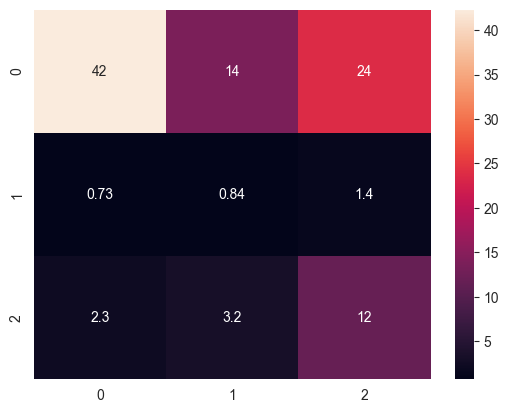

In [21]:
mat_confusion_train = np.array(mat_confusion_train)
print("Confusion matrix for train data")
sns.heatmap((mat_confusion_train / np.sum(mat_confusion_train)) * 100.0, annot=True, fmt=".2g")

Confusion matrix for test data


<AxesSubplot: >

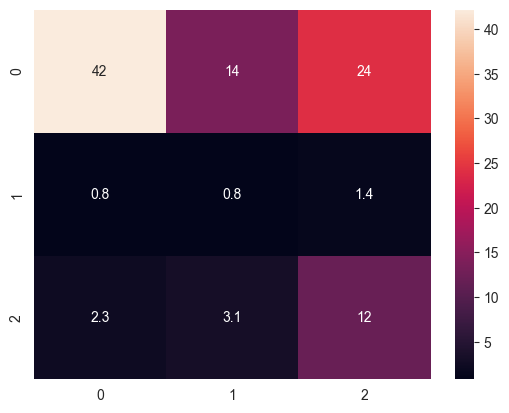

In [22]:
mat_confusion_test = np.array(mat_confusion_test)
print("Confusion matrix for test data")
sns.heatmap((mat_confusion_test / np.sum(mat_confusion_test)) * 100.0, annot=True, fmt=".2g")

C:\Users\voldo\AppData\Local\Temp\ipykernel_24092\3735943830.py:24: UserWarning: The palette list has more values (15) than needed (3), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,


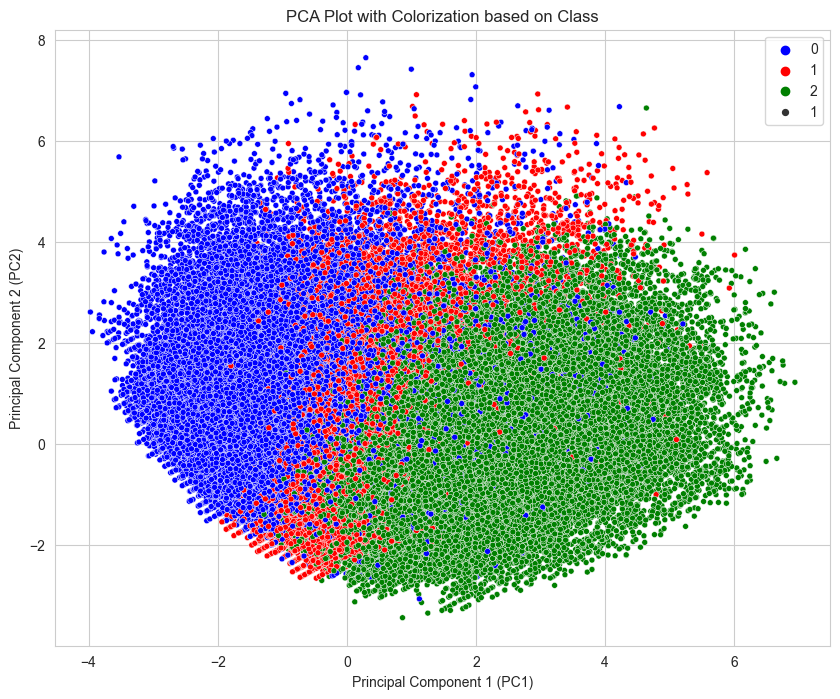

In [24]:
features = X

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(np.array(X), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        manhattan_cluster_assignment(np.array(X), obj_results.mat_cluster_centers)
y_pred = [0] * len(np.array(X))
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_all):
    for inx_ in list_clusters:
        y_pred[inx_] = cl
pca_df['class'] = y_pred

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,
                palette=['blue', 'red', 'green', 'orange', 'lime', 'purple',
                         'aqua', 'navy', 'coral', 'teal', 'mustard', 'black', 'pink',
                         'maroon', 'yellow'], size=1)
plt.title('PCA Plot with Colorization based on Class')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()

In [23]:
y_train_cl = [0] * len(y_train)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_train):
    for inx_ in list_clusters:
        y_train_cl[inx_] = cl
        
y_test_cl = [0] * len(y_test)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_test):
    for inx_ in list_clusters:
        y_test_cl[inx_] = cl
        
Y_cl = [0] * len(Y)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_Y):
    for inx_ in list_clusters:
        Y_cl[inx_] = cl

# ANN ANN FOR CLASSIFICATION

# ON ORIGINAL DATA

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape=(19,)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2560      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 52,483
Trainable params: 52,483
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss="categorical_crossentropy",
              metrics=["accuracy", ], optimizer="adam")

In [26]:
history = model.fit(
    np.array(x_train), pd.get_dummies(y_train),
    validation_data=(np.array(x_test), pd.get_dummies(y_test)),
    epochs=20,
)

Epoch 1/20
4637/4637 [==============================] - 27s 5ms/step - loss: 0.5079 - accuracy: 0.8021 - val_loss: 0.5026 - val_accuracy: 0.8035
Epoch 2/20
4637/4637 [==============================] - 24s 5ms/step - loss: 0.5015 - accuracy: 0.8051 - val_loss: 0.4994 - val_accuracy: 0.8066
Epoch 3/20
4637/4637 [==============================] - 24s 5ms/step - loss: 0.4983 - accuracy: 0.8059 - val_loss: 0.4995 - val_accuracy: 0.8043
Epoch 4/20
4637/4637 [==============================] - 23s 5ms/step - loss: 0.4974 - accuracy: 0.8062 - val_loss: 0.4983 - val_accuracy: 0.8056
Epoch 5/20
4637/4637 [==============================] - 24s 5ms/step - loss: 0.4964 - accuracy: 0.8065 - val_loss: 0.4980 - val_accuracy: 0.8065
Epoch 6/20
4637/4637 [==============================] - 23s 5ms/step - loss: 0.4958 - accuracy: 0.8069 - val_loss: 0.4965 - val_accuracy: 0.8070
Epoch 7/20
4637/4637 [==============================] - 22s 5ms/step - loss: 0.4954 - accuracy: 0.8068 - val_loss: 0.4973 - val_ac

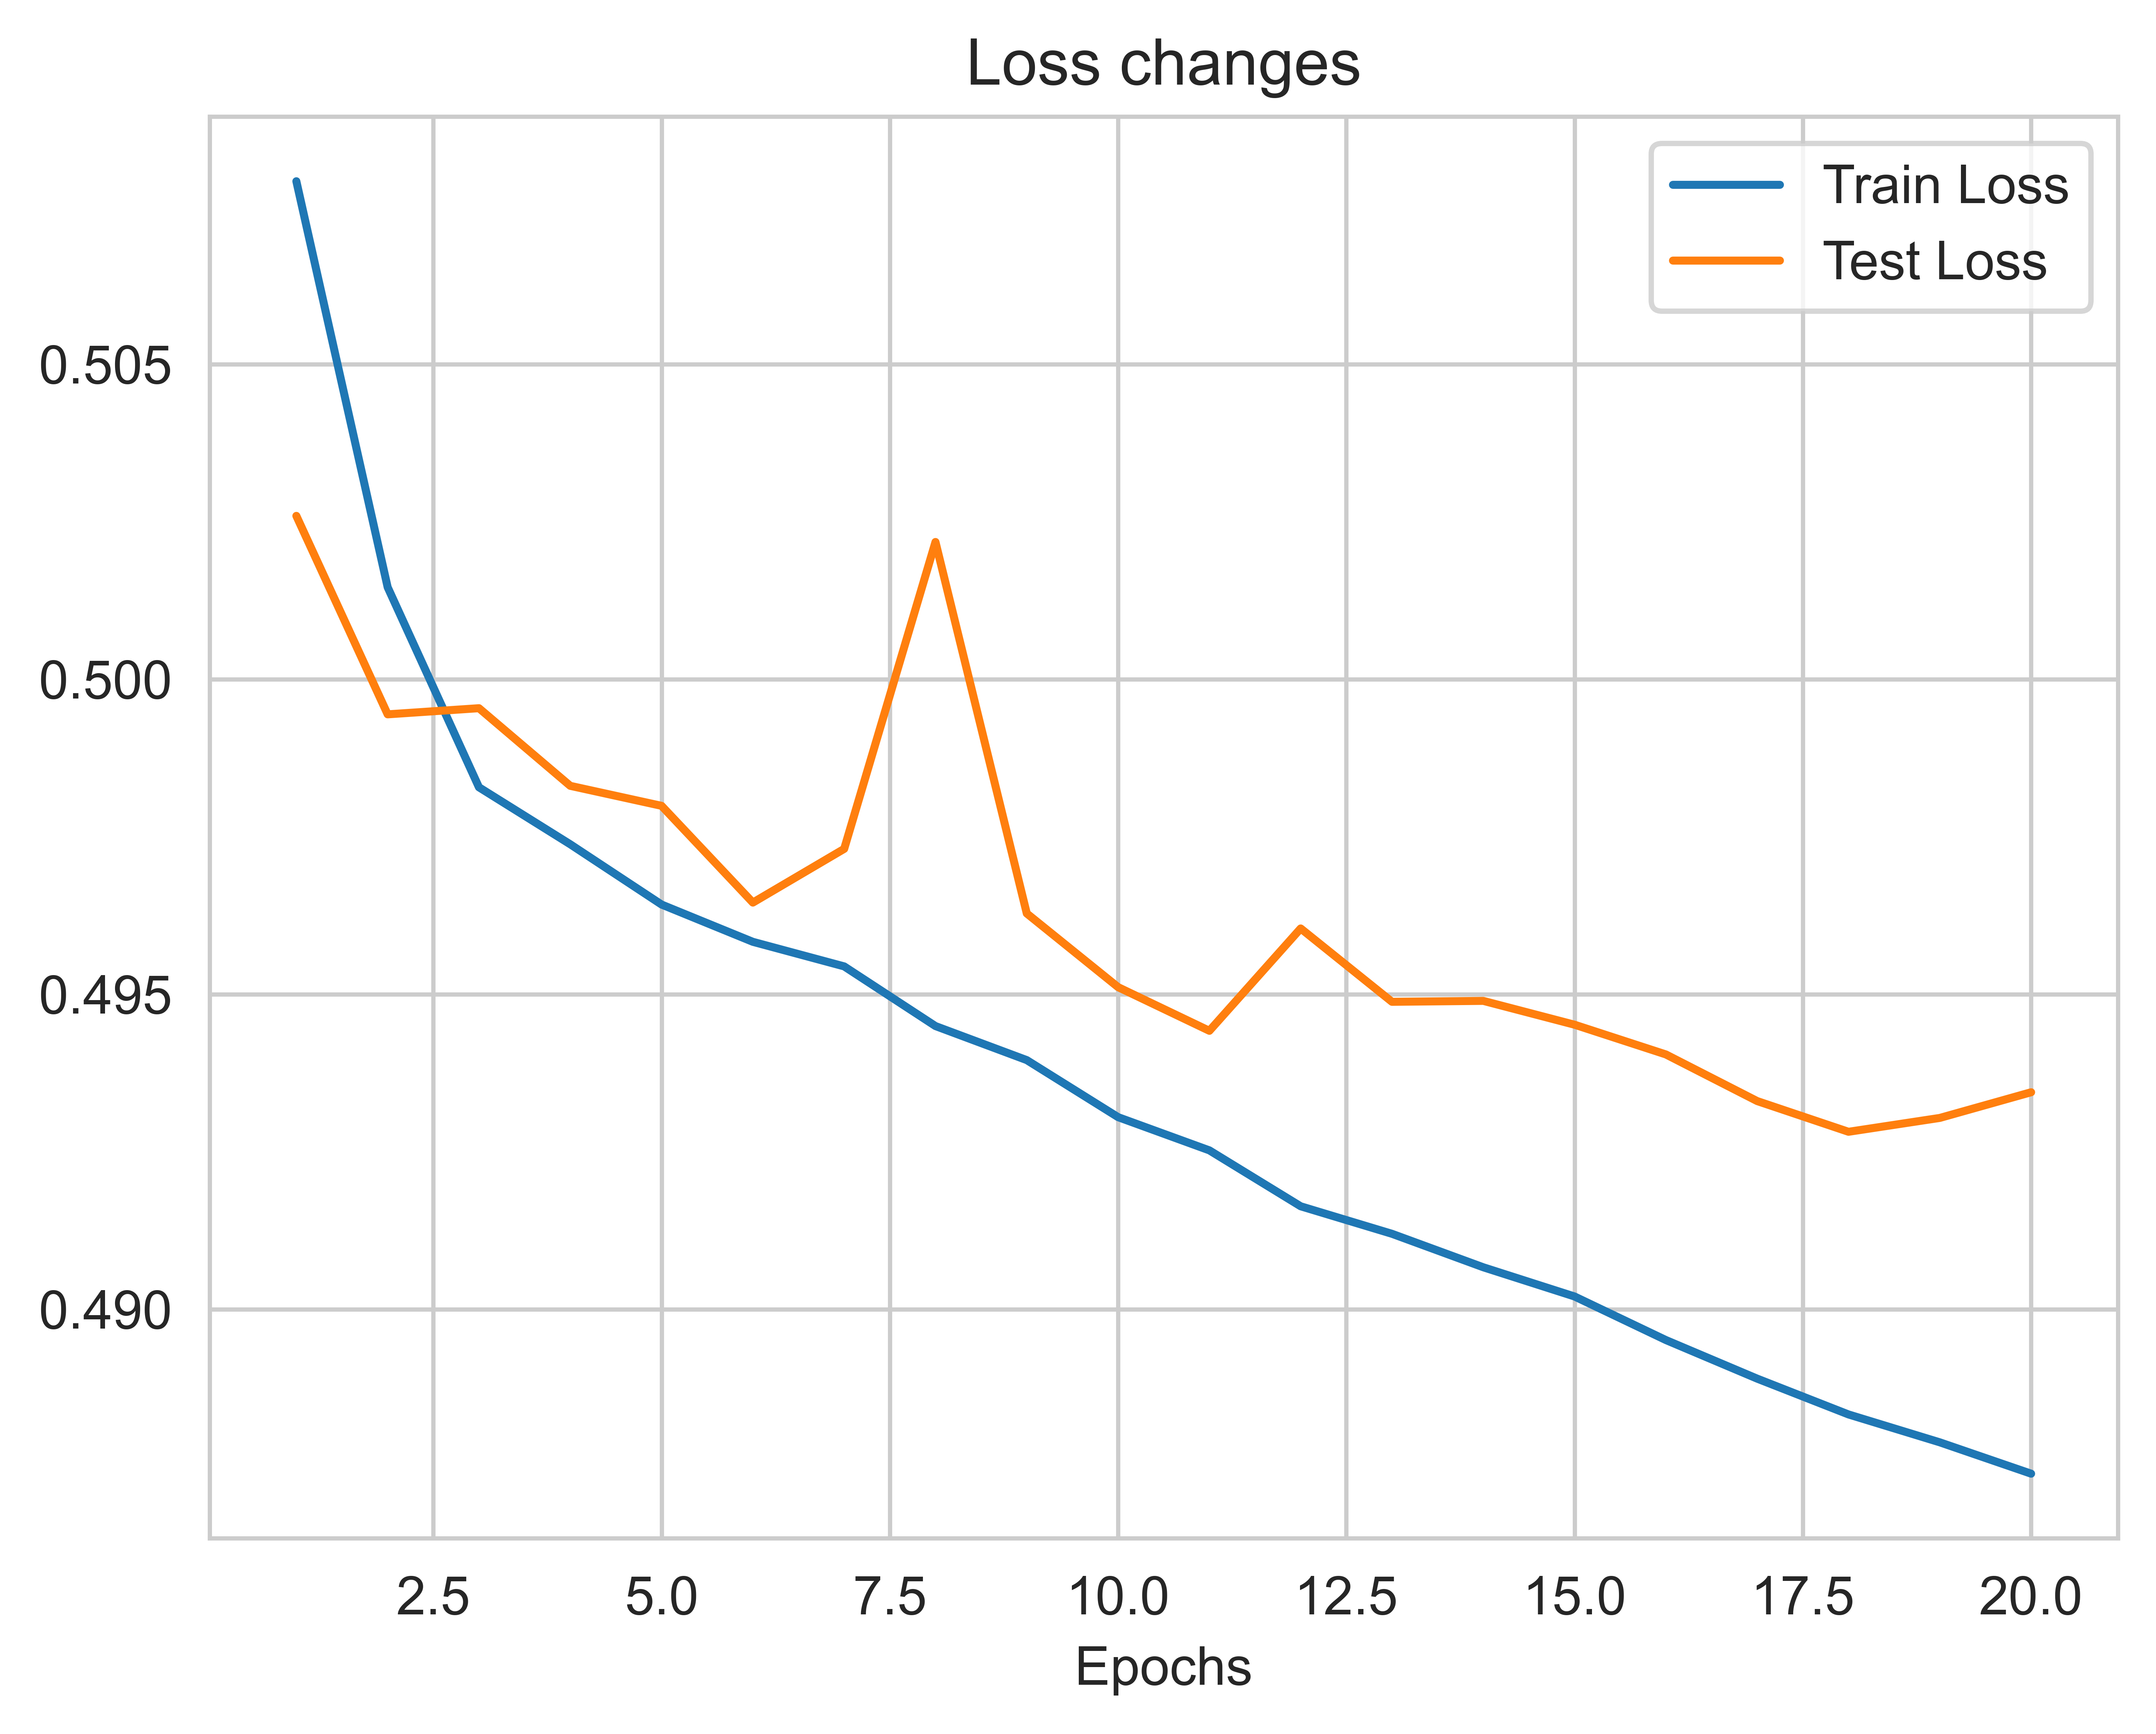

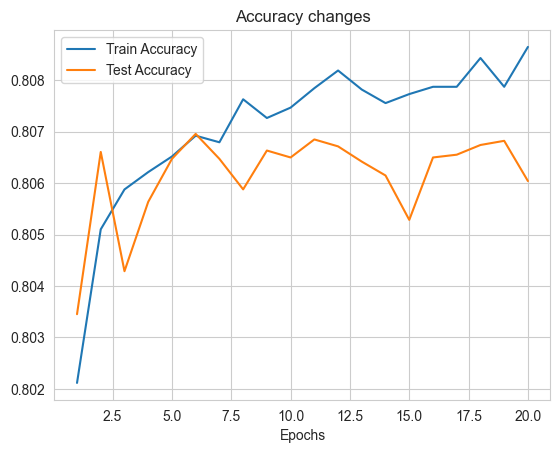

In [27]:
epochs = 20

plt.figure(dpi=1000)
plt.plot(range(1, epochs + 1), history.history['loss'], label="Train Loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="Test Loss")
plt.xlabel("Epochs")
plt.title("Loss changes")
plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['accuracy'], label="Train Accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="Test Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy changes")
plt.legend()
plt.show()

# ON LABELED DATA

In [28]:
epochs = 20

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape=(19,)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.summary()
model.compile(loss="categorical_crossentropy",
              metrics=["accuracy", ], optimizer="adam")

history = model.fit(
    np.array(x_train), pd.get_dummies(y_train_cl),
    validation_data=(np.array(x_test), pd.get_dummies(y_test_cl)),
    epochs=20,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               2560      
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 52,483
Trainable params: 52,483
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
____________________________

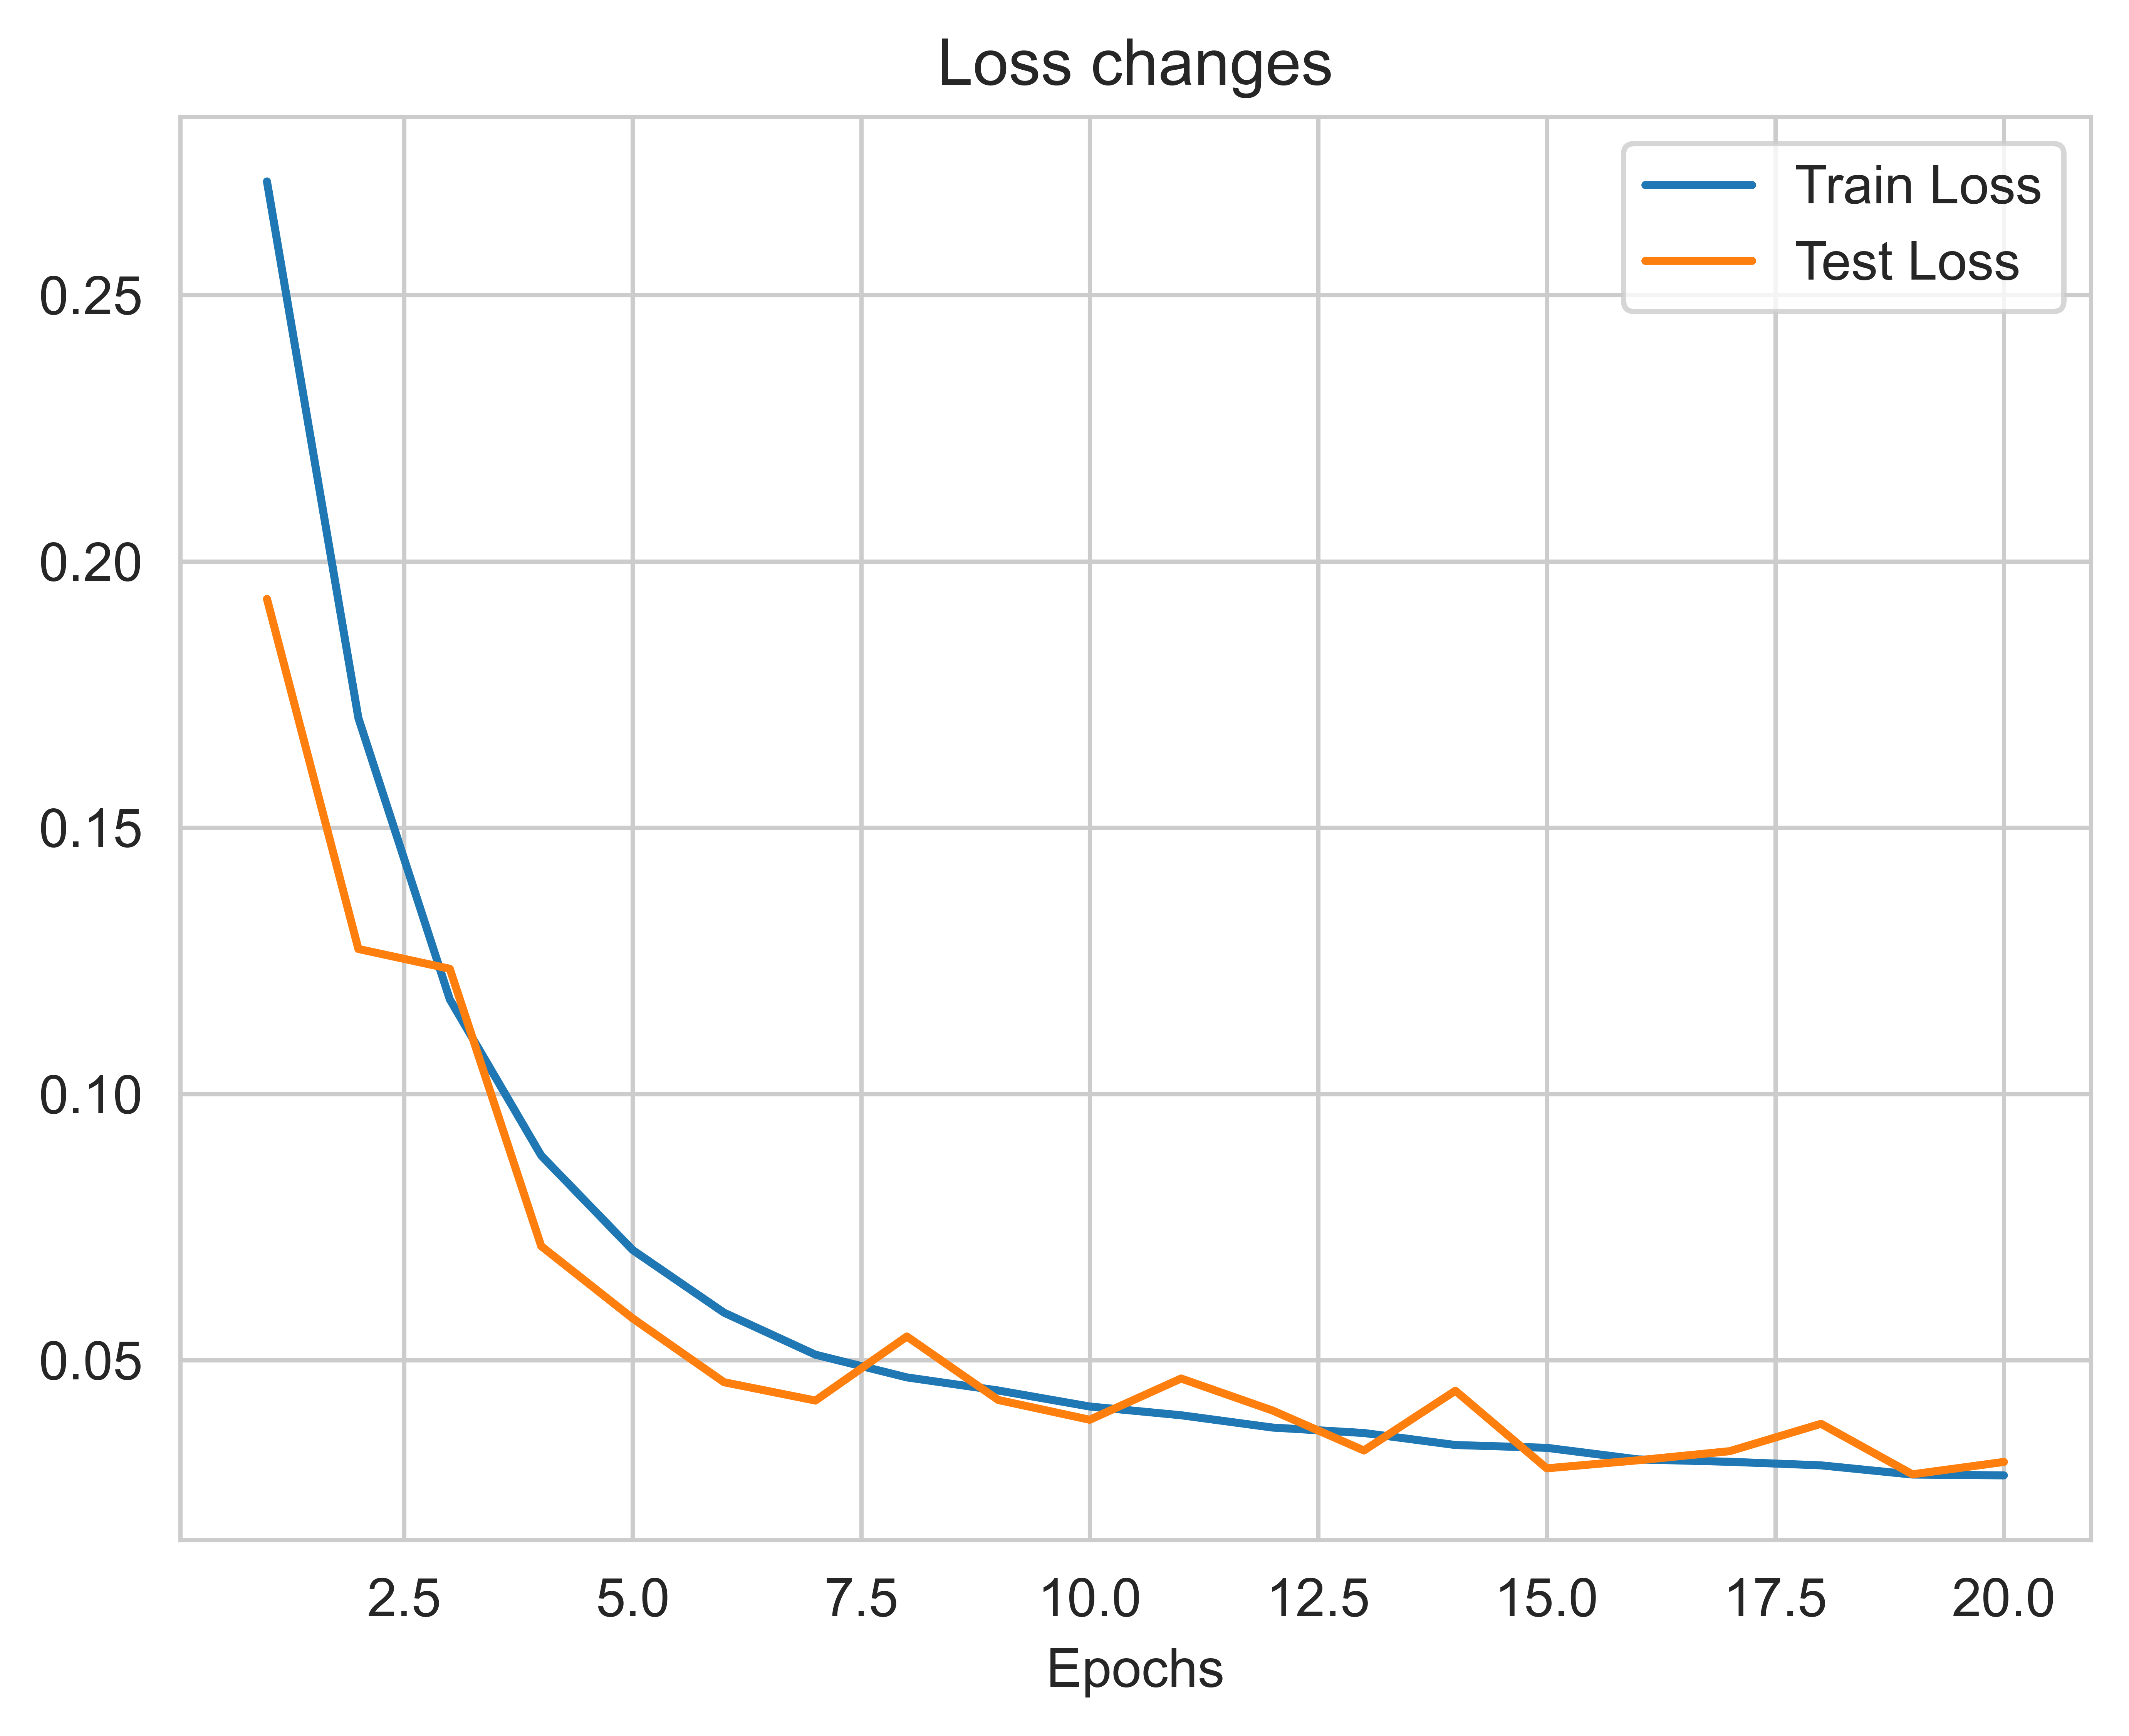

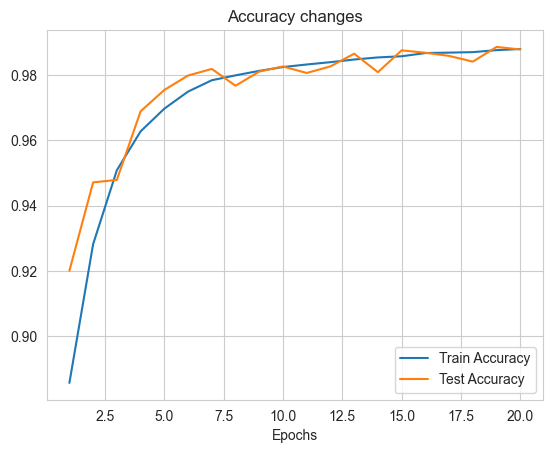

In [29]:
plt.figure(dpi=1000)
plt.plot(range(1, epochs + 1), history.history['loss'], label="Train Loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="Test Loss")
plt.xlabel("Epochs")
plt.title("Loss changes")
plt.legend()

plt.show()
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="Train Accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="Test Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy changes")
plt.legend()
plt.show()

In [35]:
mat_confusion_train = confusion_matrix(
    y_train_cl, 
    np.argmax(
        model.predict(np.array(x_train)), 
        axis=1)
)

mat_confusion_test = confusion_matrix(
    y_test_cl, 
    np.argmax(
        model.predict(np.array(x_test)), 
        axis=1)
)

1160/1160 [==============================] - 2s 2ms/step


Confusion matrix for train data


<AxesSubplot: >

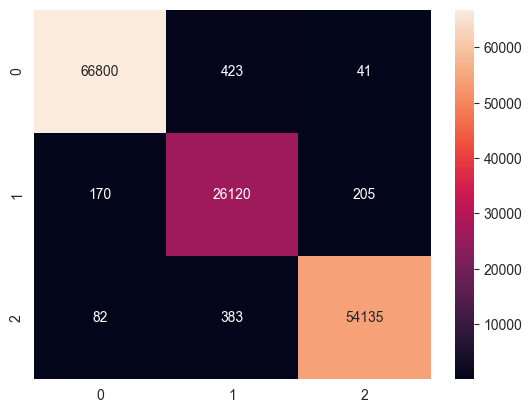

In [36]:
print("Confusion matrix for train data")
sns.heatmap(mat_confusion_train, annot=True, fmt=".0f")

Confusion matrix for test data


<AxesSubplot: >

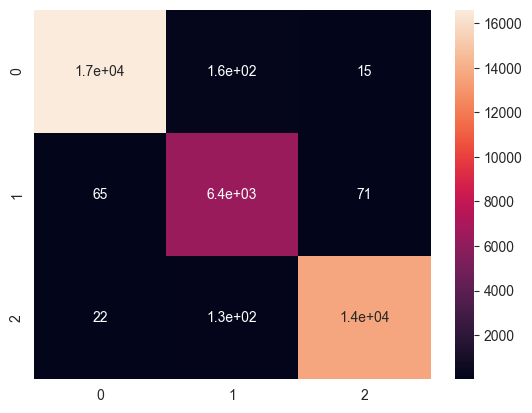

In [37]:
print("Confusion matrix for test data")
sns.heatmap(mat_confusion_test, annot=True)

In [39]:
print(f"Train accuracy: {accuracy_score(y_train_cl, np.argmax(model.predict(np.array(x_train), verbose=0), axis=1))}")
print(f"Test accuracy: {accuracy_score(y_test_cl, np.argmax(model.predict(np.array(x_test), verbose=0), axis=1))}")

Train accuracy: 0.9912105096421518
Test accuracy: 0.9874898894580749


# Gradient-Based Informativeness

In [40]:
# model_cl
loss_function = tf.keras.losses.categorical_crossentropy

with tf.GradientTape() as tape:
    inputs = tf.constant(np.array(x_train), dtype=tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    loss = loss_function(pd.get_dummies(y_train_cl), predictions)

gradients = tape.gradient(loss, inputs)
feature_importance_train = tf.reduce_mean(tf.abs(gradients), axis=0)
print(feature_importance_train.numpy() / np.sum(feature_importance_train.numpy()))

[0.04434025 0.0436413  0.1063903  0.04979003 0.01337244 0.09429071
 0.0832634  0.02530746 0.00824286 0.02589557 0.11544216 0.08445928
 0.01549388 0.06674284 0.01936276 0.03614867 0.05088308 0.02419861
 0.09273437]


In [43]:
loss_function = tf.keras.losses.categorical_crossentropy

with tf.GradientTape() as tape:
    inputs = tf.constant(np.array(x_test), dtype=tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    loss = loss_function(pd.get_dummies(y_test_cl), predictions)

gradients = tape.gradient(loss, inputs)
feature_importance_test = tf.reduce_mean(tf.abs(gradients), axis=0)
print(feature_importance_test.numpy() / np.sum(feature_importance_test.numpy()))

[0.0427678  0.04413193 0.10828844 0.05195064 0.01361438 0.09378144
 0.08397974 0.02503902 0.00812058 0.02546752 0.1168847  0.08225977
 0.01555688 0.06575055 0.01894106 0.03552959 0.05124603 0.02249637
 0.0941935 ]


In [44]:
with tf.GradientTape() as tape:
    inputs = tf.constant(np.array(X), dtype=tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    loss = loss_function(pd.get_dummies(Y_cl), predictions)

gradients = tape.gradient(loss, inputs)
feature_importance = tf.reduce_mean(tf.abs(gradients), axis=0)
print(feature_importance.numpy() / np.sum(feature_importance.numpy()))

[0.04397565 0.04375506 0.10683041 0.050291   0.01342854 0.09417262
 0.08342948 0.02524522 0.00821451 0.02579632 0.11577665 0.08394928
 0.01550849 0.06651276 0.01926499 0.03600512 0.05096725 0.02380392
 0.0930727 ]


In [45]:
pd_fi = pd.DataFrame()
pd_fi["param_name"] = list(X.columns)
pd_fi["inform_train"] = feature_importance_train.numpy() / np.sum(feature_importance_train.numpy())
pd_fi["inform_test"] = feature_importance_test.numpy() / np.sum(feature_importance_test.numpy())
pd_fi["inform"] = feature_importance.numpy() / np.sum(feature_importance.numpy())
pd_fi["inform_avg"] = pd.array(pd.array(pd_fi["inform_train"]) + pd.array(pd_fi["inform_test"]) + pd.array(pd_fi["inform"])) / 3


pd_fi = pd_fi.sort_values(by="inform_avg", ascending=False).reset_index(drop=True)
pd_fi["inform_cumulative"] = pd_fi["inform"].cumsum()

In [46]:
pd_fi.head(10)

,param_name,inform_train,inform_test,inform,inform_avg,inform_cumulative
0,HvyAlcoholConsump,0.115442,0.116885,0.115777,0.116035,0.115777
1,CholCheck,0.106390,0.108288,0.106830,0.107170,0.222607
2,Stroke,0.094291,0.093781,0.094173,0.094082,0.316780
3,Age,0.092734,0.094194,0.093073,0.093334,0.409852
4,HeartDiseaseorAttack,0.083263,0.083980,0.083429,0.083558,0.493282
5,AnyHealthcare,0.084459,0.082260,0.083949,0.083556,0.577231
6,GenHlth,0.066743,0.065751,0.066513,0.066335,0.643744
7,DiffWalk,0.050883,0.051246,0.050967,0.051032,0.694711
8,BMI,0.049790,0.051951,0.050291,0.050677,0.745002
9,HighChol,0.043641,0.044132,0.043755,0.043843,0.788757


# Integrated Gradients

In [52]:
def integrated_gradients_v2(pretrained_model, input_tensor, baseline=None, steps=50):
    """Computes integrated gradients for a model with vector output.

    Args:
        pretrained_model: A TensorFlow model with a single output tensor.
        input_tensor: A tensor representing the input to the model.
        baseline: A tensor representing the baseline input (optional).
        steps: The number of steps to use for integration.

    Returns:
        A tensor of integrated gradients, with the same shape as the input.
    """

    if baseline is None:
        baseline = tf.zeros_like(input_tensor)

    # Define a function to compute gradients for a given alpha
    def compute_gradients(alpha_):
        interpolated_input = input_tensor * alpha_
        interpolated_input += baseline + (1 - alpha_)
        with tf.GradientTape() as tape_:
            tape_.watch(interpolated_input)
            output = pretrained_model(interpolated_input)
        gradients_ = tape_.gradient(output, interpolated_input)
        return gradients_

    # Integrate gradients across multiple steps
    int_grads = tf.zeros_like(input_tensor)
    for inx in range(steps):
        alpha = (inx + 1) / (steps + 1)
        grads = compute_gradients(alpha)
        int_grads += grads

    int_grads /= steps
    return int_grads


In [53]:
integrated_grads = integrated_gradients_v2(model, tf.convert_to_tensor(X.values))

In [54]:
ig_inf_3 = integrated_grads[3] / np.max(integrated_grads[3])

df_vis = pd.DataFrame()
df_vis["param_name"] = list(X.columns)
df_vis["ig_inform_3"] = np.abs(ig_inf_3) / np.sum(np.abs(ig_inf_3))

df_vis = df_vis.sort_values(by="ig_inform_3", ascending=False).reset_index(drop=True)
df_vis.head(10)

,param_name,ig_inform_3
0,AnyHealthcare,0.176058
1,PhysActivity,0.099469
2,Stroke,0.095548
3,HeartDiseaseorAttack,0.089131
4,MentHlth,0.082007
5,HighBP,0.078612
6,Sex,0.069517
7,Veggies,0.054547
8,NoDocbcCost,0.052187
9,Age,0.045616


# Informativeness by random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train_cl)

rfctd = rfc.predict(x_test)
rfcaccuracy = accuracy_score(y_test_cl, rfctd)
print("Test:", rfcaccuracy)

rfctd = rfc.predict(x_train)
rfcaccuracy = accuracy_score(y_train_cl, rfctd)
print("Train:", rfcaccuracy)
print(rfc.feature_importances_)

Test: 0.9743057427878135
Train: 1.0
[0.10064656 0.05991212 0.02287116 0.09847876 0.01283362 0.02446761
 0.05603395 0.03027293 0.00944048 0.02291286 0.07119649 0.02195535
 0.01608032 0.10322433 0.02815414 0.05227462 0.06536632 0.02249831
 0.18138007]


In [37]:
pd_fi = pd.DataFrame()
pd_fi["param_name"] = list(X.columns)
pd_fi["inform"] = rfc.feature_importances_

pd_fi[[param_name in ["HvyAlcoholConsump", "CholCheck", "Stroke", "Age", "HeartDiseaseorAttack", "AnyHealthcare", "GenHlth", "DiffWalk", "BMI", "HighChol"] for param_name in pd_fi["param_name"]]]

,param_name,inform
1,HighChol,0.059912
2,CholCheck,0.022871
3,BMI,0.098479
5,Stroke,0.024468
6,HeartDiseaseorAttack,0.056034
10,HvyAlcoholConsump,0.071196
11,AnyHealthcare,0.021955
13,GenHlth,0.103224
16,DiffWalk,0.065366
18,Age,0.181380


# permutation importance

In [39]:
from sklearn.metrics import accuracy_score

def permutation_feature_importance(model_, x, y, metric=accuracy_score):
    x = np.array(x)
    y = np.array(y)
    baseline_score = metric(np.array([np.argmax(rec_) for rec_ in y]),
                            np.array([np.argmax(rec_) for rec_ in np.array(model_.predict(x, verbose=0))]))

    importance_scores_ = []
    for i in range(x.shape[1]):
        x_permuted = x.copy()
        np.random.shuffle(x_permuted[:, i])
        permuted_score = metric(
            np.array([np.argmax(rec_) for rec_ in y]),
            np.array([np.argmax(rec_) for rec_ in np.array(model_.predict(x_permuted, verbose=0))])
        )
        importance_scores_.append(baseline_score - permuted_score)

    return importance_scores_

In [40]:
importance_scores = permutation_feature_importance(model, x_train, y_train_cl)
print(importance_scores)

[0.005385584966196899, 0.001462668257402655, -0.01423573898449032, -0.0005324921305751573, 7.414447387754652e-05, 0.012254059409944784, 0.02172433084612324, 0.0014357066305381028, 7.414447387754652e-05, -2.0221220148386454e-05, -0.008412027581744252, -0.009746628111540256, -0.003781368167755206, 0.013319043671095099, -0.004590216973692163, 0.007407706981039264, 0.021023328547644604, 0.0023591423506494347, -0.006120289298256254]


In [41]:
importance_scores = np.array(importance_scores)
importance_scores_ = np.abs(importance_scores) / np.sum(np.abs(importance_scores))

In [42]:
pd_fi = pd.DataFrame()
pd_fi["param_name"] = list(X.columns)
pd_fi["inform"] = importance_scores_

pd_fi[[param_name in ["HvyAlcoholConsump", "CholCheck", "Stroke", "Age", "HeartDiseaseorAttack", "AnyHealthcare", "GenHlth", "DiffWalk", "BMI", "HighChol"] for param_name in pd_fi["param_name"]]]

,param_name,inform
1,HighChol,0.010919
2,CholCheck,0.106269
3,BMI,0.003975
5,Stroke,0.091476
6,HeartDiseaseorAttack,0.162172
10,HvyAlcoholConsump,0.062796
11,AnyHealthcare,0.072758
13,GenHlth,0.099426
16,DiffWalk,0.156939
18,Age,0.045688
